In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
df = pd.read_csv('/Users/ravime/Desktop/Fall 23/DLS/Proj/dataset.csv')

In [3]:
folder_path = '/Users/ravime/Desktop/Fall 23/DLS/Proj/small'
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

resized_image_data_list = []
image_names_list = []

#loop for only getting the images that are there in the score dataset
for ncesid in df['NCESID'].unique():
    image_file = f'small_{ncesid}.jpg'
    if image_file in image_files:
        sample_image_file = os.path.join(folder_path, image_file)
        img = cv2.imread(sample_image_file)
        
        #Rather than cropping, I resized/scaled the images so some important features are not lost
        resized_img = cv2.resize(img, (224, 224))
        resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        resized_image_data_list.append(resized_img_rgb)
        #list that keeps tab of the images list
        image_names_list.append(image_file)

small_60001708297.jpg


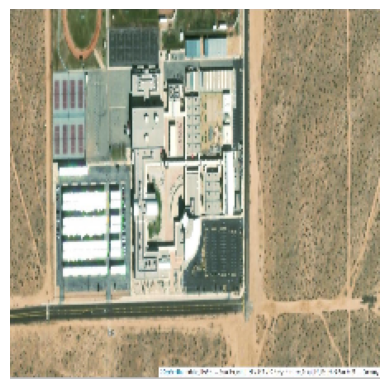

In [4]:
# Display the first resized image
print(image_names_list[8])
plt.imshow(resized_image_data_list[8])
plt.axis('off')
plt.show()

In [5]:
df.head()

,Unnamed: 0,School_ID,NCESID,NAME_x,ALL_MTH00NUMVALID_1415,ALL_MTH00PCTPROF_1415,ZIP_y,LEVEL_,FT_TEACHER
0,0,4720,60001302405,SCRIPPS RANCH HIGH,482,61,92131,HIGH,80
1,1,4721,60001311010,CHARTER SCHOOL OF SAN DIEGO,747,6,92121,HIGH,48
2,2,4748,60001312390,CLAIREMONT HIGH,244,32,92117,HIGH,43
3,3,4778,60001405093,HENRY HIGH,521,49,92120,HIGH,95
4,4,4781,60001409072,HOOVER HIGH,369,19,92115,HIGH,91


In [82]:
ncesid_values = [name.split('_')[1].split('.')[0] for name in image_names_list_l]
ncesid_values = [int(value) for value in ncesid_values]
filtered_df = df[df['NCESID'].isin(ncesid_values)]
y = filtered_df['ALL_MTH00PCTPROF_1415']*100

Image Augmentation

In [7]:
import imgaug.augmenters as iaa
from imgaug.augmenters.contrast import LinearContrast
import numpy as np

image_array = np.array(resized_image_data_list)

# Define the augmentation sequence
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),   # 50% chance of horizontal flip
    iaa.Flipud(0.5),   # 50% chance of vertical flip
    iaa.Affine(rotate=(-10, 10)),  # rotating images between -10 and 10 degrees
    iaa.Multiply((0.8, 1.2), per_channel=0.2),  # adjusting brightness
    LinearContrast((0.8, 1.2), per_channel=0.2)  # adjusting contrast
])

augmented_images = augmentation(images=image_array)

ResNet50 Model with target variable is the score

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers.legacy import Adam


X_train = np.array(augmented_images)
#normalizing images
X_train = X_train / 255.0

#resnet50 basemodel
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

#setting all the layers trainable
for layer in base_model.layers:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')])


# compiling the model with defualt learning rate and MSE as loss and MAE as metric to evaluate model.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [32]:
model.save('/Users/ravime/Desktop/Fall 23/DLS/Proj/Models/Resnet50withpct.keras')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24112513 (91.98 MB)
Trainable params: 24059393 (91.78 MB)
Non-trainable params: 53120 (207.50 KB)
__________

In [10]:
model.fit(X_train,y, epochs=70, batch_size=32, validation_split=0.2)

Epoch 1/70
23/23 [==============================] - 141s 6s/step - loss: 485.1523 - mean_absolute_error: 17.0180 - val_loss: 335.5434 - val_mean_absolute_error: 14.1154
Epoch 2/70
23/23 [==============================] - 145s 6s/step - loss: 358.0986 - mean_absolute_error: 14.8348 - val_loss: 71807.3828 - val_mean_absolute_error: 267.3635
Epoch 3/70
23/23 [==============================] - 143s 6s/step - loss: 285.3454 - mean_absolute_error: 13.1566 - val_loss: 248172.2031 - val_mean_absolute_error: 497.8469
Epoch 4/70
23/23 [==============================] - 145s 6s/step - loss: 231.4366 - mean_absolute_error: 11.9468 - val_loss: 1967.5343 - val_mean_absolute_error: 41.1810
Epoch 5/70
23/23 [==============================] - 145s 6s/step - loss: 211.8848 - mean_absolute_error: 11.1260 - val_loss: 1572.1998 - val_mean_absolute_error: 36.3306
Epoch 6/70
23/23 [==============================] - 146s 6s/step - loss: 146.6565 - mean_absolute_error: 9.3454 - val_loss: 424.6088 - val_mean_ab

In [11]:
test = X_train[0]

In [12]:
np.shape(test)

(224, 224, 3)

In [13]:
test = np.expand_dims(test, axis=0)

Predicted score for School No.1 as 63% where the actuall score was 61%

In [14]:
model.predict(test)

1/1 [==============================] - 1s 790ms/step


array([[63.08008]], dtype=float32)

Resnet50 model with target variable is percentage above or below the avg values.

In [20]:
df['ALL_MTH00PCTPROF_1415'] = df['ALL_MTH00PCTPROF_1415'] / 100
average_value = df['ALL_MTH00PCTPROF_1415'].mean()
df['difference_from_average'] = df['ALL_MTH00PCTPROF_1415'] - average_value

In [22]:
#new target variable column
y1 = df['difference_from_average']

In [24]:
base_model1 = ResNet50(include_top=False, input_shape=(224, 224, 3))

for layer in base_model1.layers:
    layer.trainable = True
model1 = models.Sequential([
    base_model1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear') ])

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [25]:
model1.fit(X_train,y1, epochs=70, batch_size=32, validation_split=0.2)

Epoch 1/70
23/23 [==============================] - 122s 5s/step - loss: 2.5986 - mean_absolute_error: 0.6172 - val_loss: 89859.0625 - val_mean_absolute_error: 299.7280
Epoch 2/70
23/23 [==============================] - 143s 6s/step - loss: 0.0346 - mean_absolute_error: 0.1461 - val_loss: 7440.8569 - val_mean_absolute_error: 86.2476
Epoch 3/70
23/23 [==============================] - 128s 6s/step - loss: 0.0342 - mean_absolute_error: 0.1461 - val_loss: 112.4380 - val_mean_absolute_error: 10.6011
Epoch 4/70
23/23 [==============================] - 131s 6s/step - loss: 0.0337 - mean_absolute_error: 0.1437 - val_loss: 0.0337 - val_mean_absolute_error: 0.1413
Epoch 5/70
23/23 [==============================] - 149s 7s/step - loss: 0.0334 - mean_absolute_error: 0.1431 - val_loss: 0.0315 - val_mean_absolute_error: 0.1438
Epoch 6/70
23/23 [==============================] - 135s 6s/step - loss: 0.0334 - mean_absolute_error: 0.1444 - val_loss: 0.0315 - val_mean_absolute_error: 0.1438
Epoch 7/7

In [26]:
test1 = X_train[0]

In [27]:
test1 = np.expand_dims(test1, axis=0)

Predicted 0.36 above avg score for 0.28

In [28]:
model1.predict(test1)

1/1 [==============================] - 1s 1s/step


array([[0.3649467]], dtype=float32)

In [29]:
y1[0]

0.28375908618899265

Model with target variable 0 if the score is below avg and 1 if its above avg

In [40]:
y2 = (df['ALL_MTH00PCTPROF_1415'] > average_value).astype(int)

In [42]:
from tensorflow.keras.applications import ResNet50

base_model2 = ResNet50(include_top=False, input_shape=(224, 224, 3))
#setting for the layers as trainable
for layer in base_model2.layers:
    layer.trainable = True

#defining the model with 2 dense layers
model2 = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')])

# compiling the model with defualt learning rate and binary crossentropy as loss.
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [44]:
model2.fit(X_train,y2, epochs=70, batch_size=32, validation_split=0.2)

Epoch 1/70
23/23 [==============================] - 149s 6s/step - loss: 1.1394 - accuracy: 0.5939 - val_loss: 853432.6250 - val_accuracy: 0.5604
Epoch 2/70
23/23 [==============================] - 157s 7s/step - loss: 0.6810 - accuracy: 0.5994 - val_loss: 42453.3477 - val_accuracy: 0.5604
Epoch 3/70
23/23 [==============================] - 158s 7s/step - loss: 0.6861 - accuracy: 0.6008 - val_loss: 300.6096 - val_accuracy: 0.5604
Epoch 4/70
23/23 [==============================] - 178s 8s/step - loss: 0.6683 - accuracy: 0.5967 - val_loss: 79.4915 - val_accuracy: 0.4396
Epoch 5/70
23/23 [==============================] - 161s 7s/step - loss: 0.6598 - accuracy: 0.5967 - val_loss: 4.4633 - val_accuracy: 0.5604
Epoch 6/70
23/23 [==============================] - 156s 7s/step - loss: 0.6448 - accuracy: 0.6064 - val_loss: 4.7315 - val_accuracy: 0.5604
Epoch 7/70
23/23 [==============================] - 147s 6s/step - loss: 0.6356 - accuracy: 0.6064 - val_loss: 0.6915 - val_accuracy: 0.5604
E

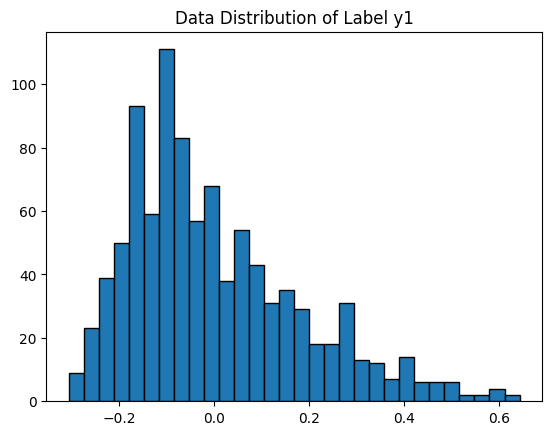

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(y1, bins=30, edgecolor='black')
plt.title('Data Distribution of Label y1')
plt.show()


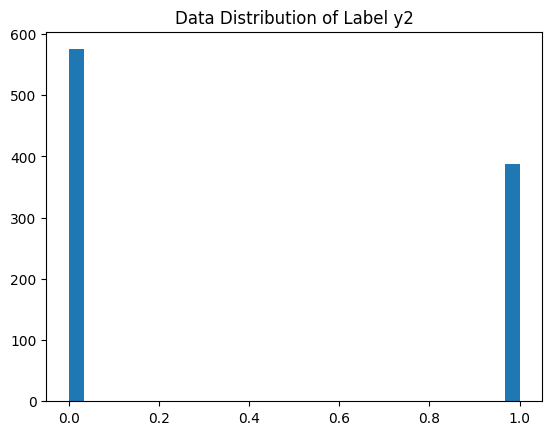

In [49]:
plt.hist(y2, bins=30)
plt.title('Data Distribution of Label y2')
plt.show()

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y3 = scaler.fit_transform(df[['ALL_MTH00PCTPROF_1415']])


In [54]:
from tensorflow.keras.applications import ResNet50

base_model3 = ResNet50(include_top=False, input_shape=(224, 224, 3))
#setting for the layers as trainable
for layer in base_model3.layers:
    layer.trainable = True

#defining the model with 2 dense layers
model3 = models.Sequential([
    base_model3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')])

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [55]:
model3.fit(X_train,y3, epochs=70, batch_size=32, validation_split=0.2)

Epoch 1/70
23/23 [==============================] - 136s 6s/step - loss: 3.6529 - mae: 0.8799 - val_loss: 1548700.0000 - val_mae: 1244.4338
Epoch 2/70
23/23 [==============================] - 142s 6s/step - loss: 0.0570 - mae: 0.1822 - val_loss: 93.6828 - val_mae: 9.6759
Epoch 3/70
23/23 [==============================] - 147s 6s/step - loss: 0.0495 - mae: 0.1741 - val_loss: 0.1364 - val_mae: 0.3334
Epoch 4/70
23/23 [==============================] - 147s 6s/step - loss: 0.0395 - mae: 0.1547 - val_loss: 1.6177 - val_mae: 1.2578
Epoch 5/70
23/23 [==============================] - 150s 7s/step - loss: 0.0354 - mae: 0.1461 - val_loss: 0.0502 - val_mae: 0.1906
Epoch 6/70
23/23 [==============================] - 146s 6s/step - loss: 0.0359 - mae: 0.1457 - val_loss: 0.0412 - val_mae: 0.1707
Epoch 7/70
23/23 [==============================] - 147s 6s/step - loss: 0.0301 - mae: 0.1347 - val_loss: 0.0469 - val_mae: 0.1597
Epoch 8/70
23/23 [==============================] - 147s 6s/step - loss: 

In [56]:
y3

array([[0.62105263],
       [0.04210526],
       [0.31578947],
       [0.49473684],
       [0.17894737],
       [0.61052632],
       [0.27368421],
       [0.47368421],
       [0.23157895],
       [0.31578947],
       [0.4       ],
       [0.6       ],
       [0.49473684],
       [0.42105263],
       [0.34736842],
       [0.36842105],
       [0.42105263],
       [0.05263158],
       [0.36842105],
       [0.12631579],
       [0.10526316],
       [0.58947368],
       [0.71578947],
       [0.54736842],
       [0.77894737],
       [0.15789474],
       [0.51578947],
       [0.54736842],
       [0.53684211],
       [0.50526316],
       [0.87368421],
       [0.22105263],
       [0.31578947],
       [0.52631579],
       [0.31578947],
       [0.61052632],
       [0.06315789],
       [0.2       ],
       [0.30526316],
       [0.15789474],
       [0.8       ],
       [0.54736842],
       [0.2       ],
       [0.32631579],
       [0.45263158],
       [0.2       ],
       [0.18947368],
       [0.326

In [57]:

folder_path = '/Users/ravime/Desktop/Fall 23/DLS/Proj/Large'
image_files_l = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

resized_image_data_list_l = []
image_names_list_l = []

#loop for only getting the images that are there in the score dataset
for ncesid in df['NCESID'].unique():
    image_file_l = f'large_{ncesid}.jpg'
    if image_file_l in image_files_l:
        sample_image_file_l = os.path.join(folder_path, image_file_l)
        img_l = cv2.imread(sample_image_file_l)
        
        #Rather than cropping, I resized/scaled the images so some important features are not lost
        resized_img_l = cv2.resize(img_l, (224, 224))
        resized_img_rgb_l = cv2.cvtColor(resized_img_l, cv2.COLOR_BGR2RGB)
        img_rgb_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB)

        
        resized_image_data_list_l.append(resized_img_rgb_l)
        #list that keeps tab of the images list
        image_names_list_l.append(image_file_l)

large_60001708297.jpg


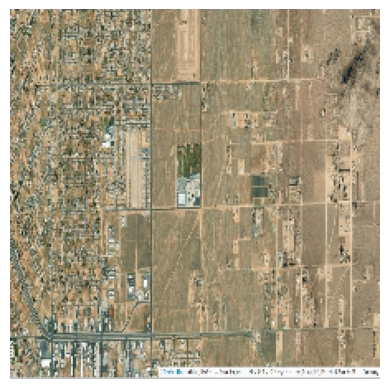

In [58]:
print(image_names_list_l[8])
plt.imshow(resized_image_data_list_l[8])
plt.axis('off')
plt.show()

small_60001708297.jpg


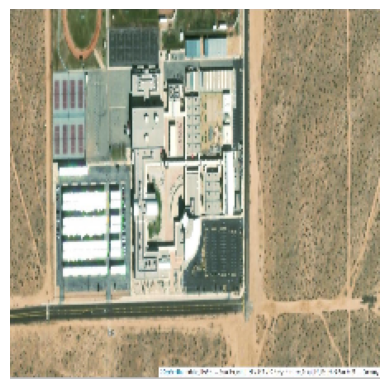

In [59]:
print(image_names_list[8])
plt.imshow(resized_image_data_list[8])
plt.axis('off')
plt.show()

In [60]:
image_array_l = np.array(resized_image_data_list_l)
augmentation_l = iaa.Sequential([
    iaa.Fliplr(0.5),   # 50% chance of horizontal flip
    iaa.Flipud(0.5),   # 50% chance of vertical flip
    iaa.Affine(rotate=(-10, 10)),  # rotating images between -10 and 10 degrees
    iaa.Multiply((0.8, 1.2), per_channel=0.2),  # adjusting brightness
    LinearContrast((0.8, 1.2), per_channel=0.2)  # adjusting contrast
])
augmented_images_l = augmentation_l(images=image_array)

In [62]:
X_train_l = np.array(augmented_images_l)

In [89]:
X_train_l = X_train_l / 255.0

In [90]:
X_train_comb = np.concatenate((X_train,X_train_l), axis=0)

In [87]:
Y_comb = np.concatenate((y, y), axis=0)

In [91]:
len(X_train_comb)

1812

In [92]:
len(Y_comb)

1812

In [93]:
base_model_l = ResNet50(include_top=False, input_shape=(224, 224, 3))

for layer in base_model_l.layers:
    layer.trainable = True

model_l = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')])

model_l.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])


In [95]:
model_l.fit(X_train_comb,Y_comb, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
46/46 [==============================] - 303s 6s/step - loss: 351.7265 - mean_absolute_error: 14.7299 - val_loss: 376.9415 - val_mean_absolute_error: 14.5608
Epoch 2/20
46/46 [==============================] - 328s 7s/step - loss: 318.0338 - mean_absolute_error: 14.1778 - val_loss: 83705.1953 - val_mean_absolute_error: 288.7301
Epoch 3/20
46/46 [==============================] - 365s 8s/step - loss: 318.8876 - mean_absolute_error: 14.0690 - val_loss: 363.0101 - val_mean_absolute_error: 14.5309
Epoch 4/20
46/46 [==============================] - 381s 8s/step - loss: 259.9800 - mean_absolute_error: 12.5680 - val_loss: 478.7844 - val_mean_absolute_error: 15.8487
Epoch 5/20
46/46 [==============================] - 390s 8s/step - loss: 242.6613 - mean_absolute_error: 12.1263 - val_loss: 342.5442 - val_mean_absolute_error: 15.0834
Epoch 6/20
46/46 [==============================] - 477s 10s/step - loss: 201.2021 - mean_absolute_error: 10.7158 - val_loss: 392.1020 - val_mean_absolu